<a href="https://www.kaggle.com/code/sahilpawar9192/river-analysis?scriptVersionId=255999327" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/river-water-segmentation-dataset/riwa_v2/validation/images/img_0815.JPG
/kaggle/input/river-water-segmentation-dataset/riwa_v2/validation/images/ADE_train_00009480.jpg
/kaggle/input/river-water-segmentation-dataset/riwa_v2/validation/images/ADE_train_00004357.jpg
/kaggle/input/river-water-segmentation-dataset/riwa_v2/validation/images/img_1041.jpg
/kaggle/input/river-water-segmentation-dataset/riwa_v2/validation/images/ADE_frame_00000082.jpg
/kaggle/input/river-water-segmentation-dataset/riwa_v2/validation/images/ADE_train_00019888.jpg
/kaggle/input/river-water-segmentation-dataset/riwa_v2/validation/images/ADE_train_00014719.jpg
/kaggle/input/river-water-segmentation-dataset/riwa_v2/validation/images/ADE_train_00024107.jpg
/kaggle/input/river-water-segmentation-dataset/riwa_v2/validation/images/img_0387.jpg
/kaggle/input/river-water-segmentation-dataset/riwa_v2/validation/images/ADE_train_00024886.jpg
/kaggle/input/river-water-segmentation-dataset/riwa_v2/validation/imag

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import Sequence
import glob
import os
import numpy as np
import cv2

In [14]:
# --- Configuration ---
class TrainConfig:
    # This should be the correct path now
    BASE_DATA_PATH = '/kaggle/input/river-water-segmentation-dataset/riwa_v2'
    
    TRAIN_IMG_DIR = os.path.join(BASE_DATA_PATH, 'train', 'images')
    TRAIN_MASK_DIR = os.path.join(BASE_DATA_PATH, 'train', 'masks')
    VAL_IMG_DIR = os.path.join(BASE_DATA_PATH, 'val', 'images')
    VAL_MASK_DIR = os.path.join(BASE_DATA_PATH, 'val', 'masks')
    
    IMG_HEIGHT = 256
    IMG_WIDTH = 256
    BATCH_SIZE = 16
    EPOCHS = 30 # Reduced for initial test, can be increased later
    LEARNING_RATE = 1e-4

In [19]:
# --- New Data Generator Class ---
# This class handles data loading manually, bypassing the tf.data.map issue.
class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, dim, n_channels=3, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_paths_temp_img = [self.image_paths[k] for k in indexes]
        list_paths_temp_mask = [self.mask_paths[k] for k in indexes]
        X, y = self.__data_generation(list_paths_temp_img, list_paths_temp_mask)
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_paths_temp_img, list_paths_temp_mask):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))
        for i, (img_path, mask_path) in enumerate(zip(list_paths_temp_img, list_paths_temp_mask)):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.dim)
            X[i,] = img / 255.0
            mask = cv2.imread(mask_path, 0)
            mask = cv2.resize(mask, self.dim, interpolation=cv2.INTER_NEAREST)
            y[i,] = np.expand_dims(mask, axis=-1) / 255.0
        return X, np.round(y)

In [21]:
# --- Prepare file lists ---
print("--- Searching for files with the correct paths ---")
train_image_paths = sorted(glob.glob(os.path.join(TrainConfig.TRAIN_IMG_DIR, '*.jpg')))
train_mask_paths = sorted(glob.glob(os.path.join(TrainConfig.TRAIN_MASK_DIR, '*.png')))
val_image_paths = sorted(glob.glob(os.path.join(TrainConfig.VAL_IMG_DIR, '*.jpg')))
val_mask_paths = sorted(glob.glob(os.path.join(TrainConfig.VAL_MASK_DIR, '*.png')))
print(f"Found {len(train_image_paths)} training images.")
print(f"Found {len(val_image_paths)} validation images.")

--- Searching for files with the correct paths ---
Found 0 training images.
Found 0 validation images.


In [18]:
# --- Model Definition (Same as before) ---
def build_mobilenetv2_unet(input_shape=(256, 256, 3)):
    encoder = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    skip_connections = ['block_1_expand_relu', 'block_3_expand_relu', 'block_6_expand_relu', 'block_13_expand_relu', 'out_relu']
    encoder_outputs = [encoder.get_layer(name).output for name in skip_connections]
    down_stack = Model(inputs=encoder.input, outputs=encoder_outputs)
    inputs = Input(shape=input_shape)
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    up_stack = [Conv2DTranspose(filters, 2, strides=2, padding='same') for filters in [512, 256, 128, 64]]
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])
    last = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')
    return Model(inputs=inputs, outputs=last(x))

class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, name='mean_io_u', num_classes=2, **kwargs):
        super(MeanIoU, self).__init__(num_classes=num_classes, name=name, **kwargs)
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.round(y_pred)
        return super().update_state(y_true, y_pred, sample_weight)

# --- Compile and Train ---
model = build_mobilenetv2_unet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=TrainConfig.LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', MeanIoU(num_classes=2)]
)
model.summary()

print("\n--- Starting Model Training ---")
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=TrainConfig.EPOCHS
)

print("\n--- Training Complete ---")

/tmp/ipykernel_36/2570548993.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  encoder = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_6        │ [(None, 128, 128, │  2,257,984 │ input_layer_7[0]… │
│ (Functional)        │ 96), (None, 64,   │            │                   │
│                     │ 64, 144), (None,  │            │                   │
│                     │ 32, 32, 192),     │            │                   │
│                     │ (None, 16, 16,    │            │                   │
│                     │ 576), (None, 8,   │            │                   │
│                     │ 8, 1280)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_15 │ (None, 16, 16,    │  2,621,952 │ functional_6[0][… │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1088)             │            │ functional_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_16 │ (None, 32, 32,    │  1,114,368 │ concatenate_12[0… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 448)              │            │ functional_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_17 │ (None, 64, 64,    │    229,504 │ concatenate_13[0… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 272)              │            │ functional_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_18 │ (None, 128, 128,  │     69,696 │ concatenate_14[0… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_15      │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 160)              │            │ functional_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_19 │ (None, 256, 256,  │      1,441 │ concatenate_15[0… │
│ (Conv2DTranspose)   │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,294,945 (24.01 MB)

 Trainable params: 6,260,833 (23.88 MB)

 Non-trainable params: 34,112 (133.25 KB)


--- Starting Model Training ---


ValueError: The PyDataset has length 0

In [24]:
# --- FINAL FOLDER INSPECTION ---
import os

# The path you confirmed
images_dir = '/kaggle/input/river-water-segmentation-dataset/riwa_v2/images'

print(f"--- Inspecting contents of: {images_dir} ---")

try:
    # List everything inside this folder
    contents = os.listdir(images_dir)
    
    if not contents:
        print("❌ The folder is EMPTY.")
    else:
        print(f"✅ Found {len(contents)} items. Here are the first 10:")
        for item in contents[:10]:
            print(f" -> {item}")

except FileNotFoundError:
    print(f"❌ FATAL ERROR: The path '{images_dir}' does not exist.")

--- Inspecting contents of: /kaggle/input/river-water-segmentation-dataset/riwa_v2/images ---
✅ Found 1142 items. Here are the first 10:
 -> ADE_train_00023712.jpg
 -> img_0420.jpg
 -> ADE_train_00009895.jpg
 -> img_0441.jpg
 -> ADE_train_00011031.jpg
 -> img_442672.jpg
 -> ADE_train_00024702.jpg
 -> img_0104.jpg
 -> img_0826.jpg
 -> img_0982.jpg


In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import glob
import os
import numpy as np
import cv2

# --- Configuration ---
class TrainConfig:
    BASE_DATA_PATH = '/kaggle/input/river-water-segmentation-dataset/riwa_v2'
    IMG_DIR = os.path.join(BASE_DATA_PATH, 'images')
    MASK_DIR = os.path.join(BASE_DATA_PATH, 'masks')
    IMG_HEIGHT = 256
    IMG_WIDTH = 256
    BATCH_SIZE = 16
    EPOCHS = 30
    LEARNING_RATE = 1e-4

# --- Data Generator Class (Unchanged) ---
class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size, dim, n_channels=3, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_paths_temp_img = [self.image_paths[k] for k in indexes]
        list_paths_temp_mask = [self.mask_paths[k] for k in indexes]
        X, y = self.__data_generation(list_paths_temp_img, list_paths_temp_mask)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_paths_temp_img, list_paths_temp_mask):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))
        for i, (img_path, mask_path) in enumerate(zip(list_paths_temp_img, list_paths_temp_mask)):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.dim)
            X[i,] = img / 255.0
            mask = cv2.imread(mask_path, 0)
            mask = cv2.resize(mask, self.dim, interpolation=cv2.INTER_NEAREST)
            y[i,] = np.expand_dims(mask, axis=-1) / 255.0
        return X, np.round(y)

# --- NEW: Robust File Matching and Splitting ---
print("--- Searching for files and creating matched pairs ---")
all_image_paths = sorted(glob.glob(os.path.join(TrainConfig.IMG_DIR, '*.jpg')))
all_mask_paths = sorted(glob.glob(os.path.join(TrainConfig.MASK_DIR, '*.png')))

# Create a dictionary of mask names for quick lookup
mask_names = {os.path.splitext(os.path.basename(p))[0]: p for p in all_mask_paths}

# Find the common files
matched_images = []
matched_masks = []
for img_path in all_image_paths:
    img_name = os.path.splitext(os.path.basename(img_path))[0]
    if img_name in mask_names:
        matched_images.append(img_path)
        matched_masks.append(mask_names[img_name])

print(f"Found {len(matched_images)} fully matched image-mask pairs.")

# We will now split the matched data
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    matched_images, matched_masks, test_size=0.15, random_state=42
)
print(f"-> Using {len(train_image_paths)} for training and {len(val_image_paths)} for validation.")

# --- Instantiate Generators ---
training_generator = DataGenerator(train_image_paths, train_mask_paths, TrainConfig.BATCH_SIZE, (TrainConfig.IMG_HEIGHT, TrainConfig.IMG_WIDTH))
validation_generator = DataGenerator(val_image_paths, val_mask_paths, TrainConfig.BATCH_SIZE, (TrainConfig.IMG_HEIGHT, TrainConfig.IMG_WIDTH))

# --- Model Definition (Same as before) ---
def build_mobilenetv2_unet(input_shape=(256, 256, 3)):
    encoder = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    skip_connections = ['block_1_expand_relu', 'block_3_expand_relu', 'block_6_expand_relu', 'block_13_expand_relu', 'out_relu']
    encoder_outputs = [encoder.get_layer(name).output for name in skip_connections]
    down_stack = Model(inputs=encoder.input, outputs=encoder_outputs)
    inputs = Input(shape=input_shape)
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    up_stack = [Conv2DTranspose(filters, 2, strides=2, padding='same') for filters in [512, 256, 128, 64]]
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])
    last = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')
    return Model(inputs=inputs, outputs=last(x))

class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, name='mean_io_u', num_classes=2, **kwargs):
        super(MeanIoU, self).__init__(num_classes=num_classes, name=name, **kwargs)
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.round(y_pred)
        return super().update_state(y_true, y_pred, sample_weight)

# --- Compile and Train ---
model = build_mobilenetv2_unet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=TrainConfig.LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', MeanIoU(num_classes=2)]
)
model.summary()

print("\n--- Starting Model Training ---")
history = model.fit(
    training_generator,
    validation_data=validation_generator,
    epochs=TrainConfig.EPOCHS
)
print("\n--- Training Complete ---")

--- Searching for files and creating matched pairs ---
Found 1027 fully matched image-mask pairs.
-> Using 872 for training and 155 for validation.


/tmp/ipykernel_36/612226788.py:93: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  encoder = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_12       │ [(None, 128, 128, │  2,257,984 │ input_layer_13[0… │
│ (Functional)        │ 96), (None, 64,   │            │                   │
│                     │ 64, 144), (None,  │            │                   │
│                     │ 32, 32, 192),     │            │                   │
│                     │ (None, 16, 16,    │            │                   │
│                     │ 576), (None, 8,   │            │                   │
│                     │ 8, 1280)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_30 │ (None, 16, 16,    │  2,621,952 │ functional_12[0]… │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_24      │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1088)             │            │ functional_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_31 │ (None, 32, 32,    │  1,114,368 │ concatenate_24[0… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_25      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 448)              │            │ functional_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_32 │ (None, 64, 64,    │    229,504 │ concatenate_25[0… │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_26      │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 272)              │            │ functional_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_33 │ (None, 128, 128,  │     69,696 │ concatenate_26[0… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_27      │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 160)              │            │ functional_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_34 │ (None, 256, 256,  │      1,441 │ concatenate_27[0… │
│ (Conv2DTranspose)   │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,294,945 (24.01 MB)

 Trainable params: 6,260,833 (23.88 MB)

 Non-trainable params: 34,112 (133.25 KB)


--- Starting Model Training ---
Epoch 1/30


I0000 00:00:1755186636.779683     102 service.cc:148] XLA service 0x7f7728004190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755186636.780556     102 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755186640.390343     102 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1755186646.257789     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755186646.453212     102 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 2/54 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.5390 - loss: 0.7359 - mean_io_u: 0.3421  

I0000 00:00:1755186657.951974     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 ━━━━━━━━━━━━━━━━━━━━ 93s 621ms/step - accuracy: 0.6302 - loss: 0.6472 - mean_io_u: 0.3729 - val_accuracy: 0.7691 - val_loss: 0.6232 - val_mean_io_u: 0.4778
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 361ms/step - accuracy: 0.8391 - loss: 0.3319 - mean_io_u: 0.6766 - val_accuracy: 0.8343 - val_loss: 0.6495 - val_mean_io_u: 0.6716
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 369ms/step - accuracy: 0.9109 - loss: 0.2119 - mean_io_u: 0.8117 - val_accuracy: 0.7985 - val_loss: 0.9069 - val_mean_io_u: 0.6344
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - accuracy: 0.9374 - loss: 0.1546 - mean_io_u: 0.8631 - val_accuracy: 0.8071 - val_loss: 0.9660 - val_mean_io_u: 0.6455
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 388ms/step - accuracy: 0.9450 - loss: 0.1359 - mean_io_u: 0.8803 - val_accuracy: 0.8206 - val_loss: 1.0198 - val_mean_io_u: 0.6632
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 364ms/step - accuracy: 0.9516 - loss: 0.1227 - mean_io_u: 0.8914 - val_accuracy: 0.8107 - val_loss: 1.06

--- Plotting Training and Validation Metrics ---


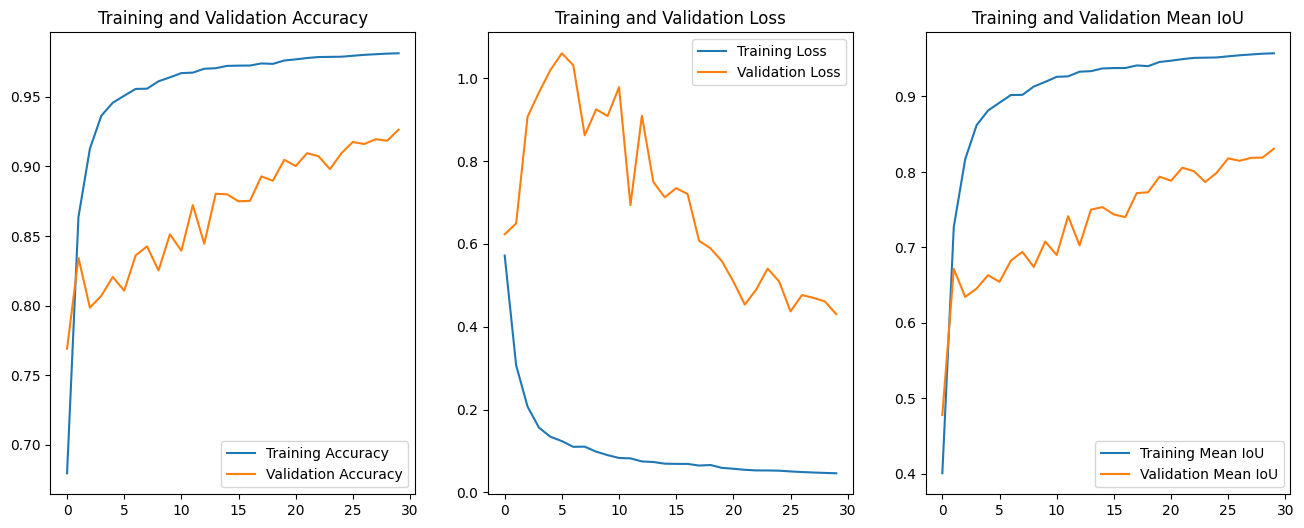

In [28]:
import matplotlib.pyplot as plt

# --- Plot Training History ---
print("--- Plotting Training and Validation Metrics ---")

# Extract history from the 'history' object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
mean_iou = history.history['mean_io_u']
val_mean_iou = history.history['val_mean_io_u']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 6))

# Plot Accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Plot Mean IoU
plt.subplot(1, 3, 3)
plt.plot(epochs_range, mean_iou, label='Training Mean IoU')
plt.plot(epochs_range, val_mean_iou, label='Validation Mean IoU')
plt.legend(loc='lower right')
plt.title('Training and Validation Mean IoU')

plt.show()

In [29]:
# --- Save the Model ---
print("--- Saving the trained model ---")

# Save the optimized TFLite model for edge deployment
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # This enables 8-bit quantization
tflite_quant_model = converter.convert()

with open('water_segmentation_model.tflite', 'wb') as f:
    f.write(tflite_quant_model)

print("✅ TFLite model saved as water_segmentation_model.tflite")

--- Saving the trained model ---
Saved artifact at '/tmp/tmpny0vyeiy'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_1168')
Output Type:
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)
Captures:
  140150922328592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150891905296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150891906064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150922329552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150891905104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150891907408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150891907792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150891908176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150891907984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140150891905872: TensorSpec(shape=()

W0000 00:00:1755187981.909073      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1755187981.909123      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1755187982.028991      36 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
